## spell check

In [1]:
import numpy as np
import pandas as pd 
import os 

In [2]:
data_path = 'dataset/Metal_Content_of_Consumer_Products_Tested_by_the_NYC_Health_Department_20240403.csv'
df = pd.read_csv(data_path)

#### using spellchecker library to tag the data

In [16]:
from spellchecker import SpellChecker
import re
spell = SpellChecker()

def keep_letters_spaces_single_space(text):
    if isinstance(text, str):  # Ensure the input is a string
        text = re.sub(' +', ' ', re.sub('[^a-zA-Z\s]', '', text))
    else:
        text = ''  # If text is not a string, return an empty string
    return text

def find_misspellings(text):
    # Ensure that text is a string, otherwise, convert it to a string
    text = str(text) if not isinstance(text, str) else text
    text = keep_letters_spaces_single_space(text)
    words = text.split()
    misspelled = spell.unknown(words)
    return ', '.join(misspelled)


df['MANUFACTURER_MISSPELLED'] = df['MANUFACTURER'].apply(find_misspellings)

for index, row in df.iterrows():
    if row['MANUFACTURER_MISSPELLED']!='':
        print(f"{row['MANUFACTURER']} | {row['MANUFACTURER_MISSPELLED']}")


['lucas', 'muecas'] | lucas, muecas
['pvt.', 'ajmera', 'ltd.'] | ajmera, pvt, ltd
['meyer', 'vitabiotics'] | meyer, vitabiotics
['frito'] | frito
['frito'] | frito
['oleh', 'dipsoduske'] | oleh, dipsoduske
['viacom'] | viacom
['prodravka'] | prodravka
['pvt.', 'ltd', 'ajanta'] | ajanta, pvt, ltd
['omkara'] | omkara
['dulces', 'vero'] | dulces, vero
['corp'] | corp
['cetamol'] | cetamol
['ltd', 'co.', 'p.a.'] | co, ltd
['dabur', 'ltd.'] | ltd, dabur
['dabur', 'ltd.'] | ltd, dabur
['dabur', 'ltd.'] | ltd, dabur
['vyas'] | vyas
['vyas'] | vyas
['vyas'] | vyas
['dulces', 'vero'] | dulces, vero
['preema', 'ltd'] | preema, ltd
['azteca'] | azteca
['totis'] | totis
['radhuni'] | radhuni
['radhuni'] | radhuni
['radhuni'] | radhuni
['pharmacuetical'] | pharmacuetical
['aci'] | aci
['pharma'] | pharma
['ltd', 'products,'] | ltd
['ltd', 'products,'] | ltd
['ltd', 'products,'] | ltd
['ltd.', 'products,'] | ltd
['yiyuan'] | yiyuan
['yiyuan'] | yiyuan
['yiyuan'] | yiyuan
['malla', 'grupo'] | malla, 

In [40]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
df['MANUFACTURER_MISSPELLED'] = df['MANUFACTURER_MISSPELLED'].apply(lambda x: bool(x))

#### using GloVe to predict

In [26]:
def read_glove_vecs(glove_file):
    with open(glove_file,'r') as f:
        words=set()
        for line in f:
            line=line.strip().split()
            curr_word=line[0]
            words.add(curr_word)
        i=1
        words_to_index={}
        for w in sorted(words):
            words_to_index[w]=i
            i=i+1
    del words
    return words_to_index

In [27]:
WORDS=read_glove_vecs('dataset/glove.6B.50d.txt')

In [28]:
import re 
from collections import Counter
def words(text):
    return re.findall(r'\w+', text.lower())
def P(word):
    return -WORDS.get(word,0)
def correction(word):
    return max(candidates(word), key=P)
def candidates(word):
    c =  (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])
    return c
def known(ws):
    return set(w for w in ws if w in WORDS)
def edits1(word):
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)
def edits2(word):
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [35]:
import pandas as pd
import re
def find_corrections(text):
    arr = text
    corrections_list = []
    for s in arr:
        s = s.lower()
        if s and correction(s) != s:
            corrections_list.append((s, correction(s)))
    return corrections_list
df['pred'] = False
corrections = []
for index, line in df['MANUFACTURER'].items():
    row_corrections = find_corrections(line)
    corrections += row_corrections
    if row_corrections:
        df.at[index, 'pred'] = True

corrections_df = pd.DataFrame(corrections, columns=['Error Word', 'Corrected Word'])

print(corrections_df)


     Error Word Corrected Word
0        muecas          aucas
1        ajmera          ajmer
2     prodravka       podravka
3       cetamol         ekamol
4        preema         freema
...         ...            ...
1177       m/s.            m/s
1178    harmain       haramain
1179      abido           abdo
1180      bhcpl           bcpl
1181        a.q             a.

[1182 rows x 2 columns]


/var/folders/dt/c_0ljg_n3_91zr9wrh09snf40000gn/T/ipykernel_30831/3865125503.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=error_word_counts.index, x=error_word_counts.values, palette="Blues_d")


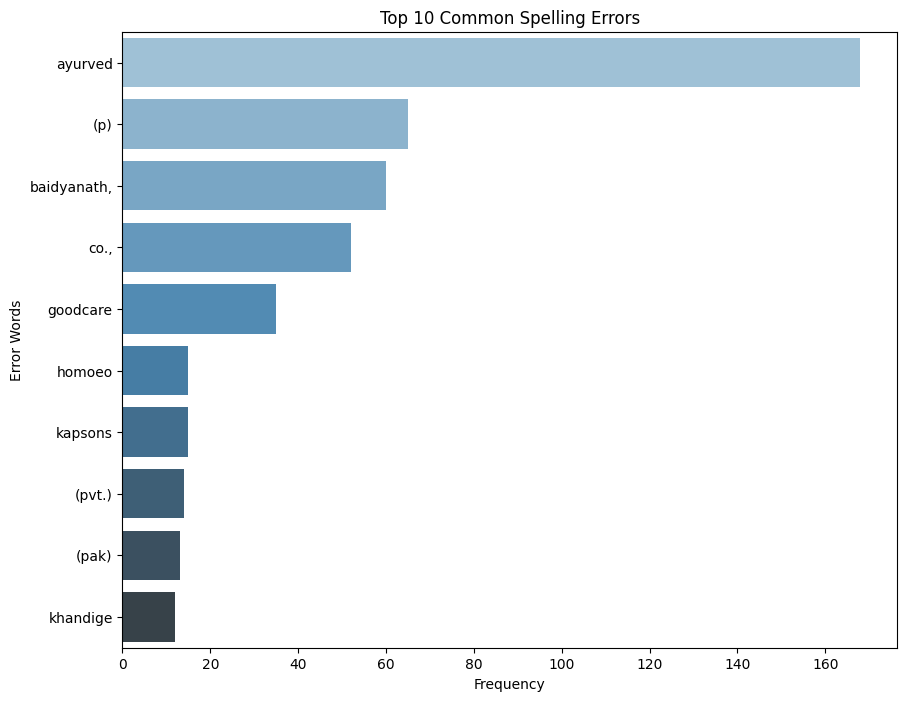

/var/folders/dt/c_0ljg_n3_91zr9wrh09snf40000gn/T/ipykernel_30831/3865125503.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=corrected_word_counts.index, x=corrected_word_counts.values, palette="Greens_d")


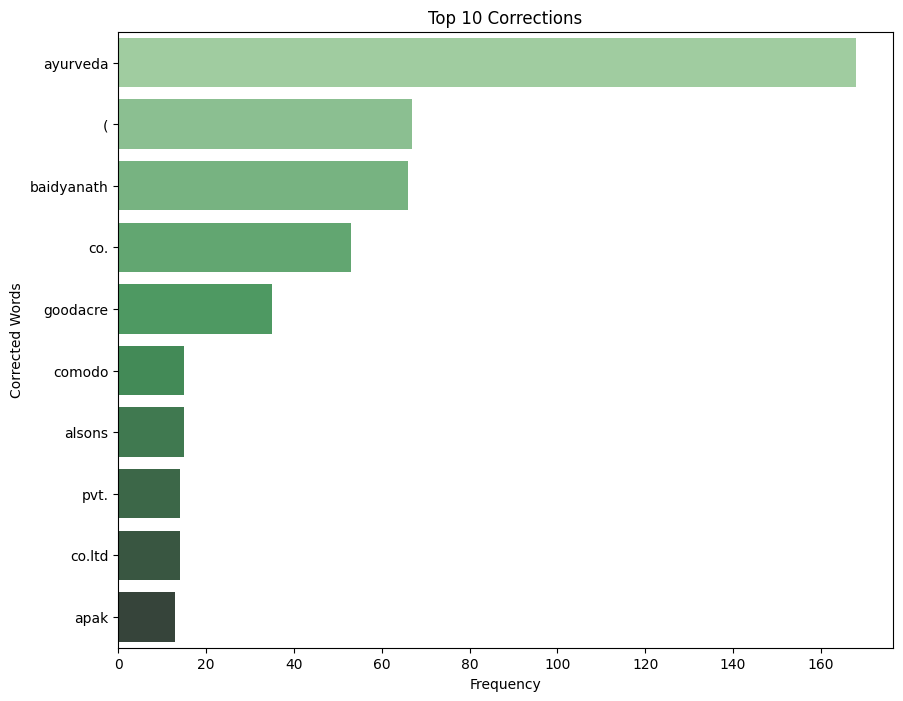

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

error_word_counts = corrections_df['Error Word'].value_counts().head(10)

corrected_word_counts = corrections_df['Corrected Word'].value_counts().head(10)

plt.figure(figsize=(10, 8))
sns.barplot(y=error_word_counts.index, x=error_word_counts.values, palette="Blues_d")
plt.title('Top 10 Common Spelling Errors')
plt.xlabel('Frequency')
plt.ylabel('Error Words')
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(y=corrected_word_counts.index, x=corrected_word_counts.values, palette="Greens_d")
plt.title('Top 10 Corrections')
plt.xlabel('Frequency')
plt.ylabel('Corrected Words')
plt.show()


#### calculate the evaluation

In [41]:
y_true=df['MANUFACTURER_MISSPELLED']
y_pred=df['pred']
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8584070796460177
Precision: 0.9831838565022422
Recall: 0.4771490750816104
F1 Score: 0.6424908424908425


In [42]:
out_put='misspell_out_put.csv'
df.to_csv(out_put, index=False)